In [2]:
from typing import *

import random

import matplotlib.pyplot as plt
import numpy
import matplotlib
from matplotlib.axes._axes import Axes

# 定义环境
class GridWorld:
    def __init__(
            self, 
            rows : int, 
            cols : int, 
            start : Tuple[int, int], 
            goal : Tuple[int, int], 
            obstacles : List[Tuple[int, int]]
    ):
        self.rows = rows
        self.cols = cols
        self.start = start
        self.goal = goal
        self.obstacles = obstacles
        self.state = start

    def reset(self) -> Tuple[int, int]:
        self.state = self.start
        return self.state

    def move(self, action) -> Tuple:
        next_state = None
        if action == 0:  # 上
            next_state = (self.state[0] - 1, self.state[1])
        elif action == 1:  # 下
            next_state = (self.state[0] + 1, self.state[1])
        elif action == 2:  # 左
            next_state = (self.state[0], self.state[1] - 1)
        elif action == 3:  # 右
            next_state = (self.state[0], self.state[1] + 1)

        # 考虑碰到边缘和障碍物的情况
        if (0 <= next_state[0] < self.rows and
                0 <= next_state[1] < self.cols and
                next_state not in self.obstacles):
            self.state = next_state

        if self.state == self.goal:
            return self.state, 1, True  # 到达目标，奖励1
        return self.state, -0.1, False  # 每步惩罚

# SARSA算法
class SARSAAgent:
    def __init__(self, actions : List[int], alpha : float=0.1, gamma : float=0.9, epsilon : float=0.1):
        self.q_table = {}
        self.actions = actions
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # 探索率

    def get_q_value(self, state, action) -> float:
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state : Tuple[int, int]) -> int:
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(self.actions)  # 探索
        else:
            q_values = [self.get_q_value(state, a) for a in self.actions]
            max_q = max(q_values)
            return self.actions[q_values.index(max_q)]  

    def update_q_value(
              self, 
              state : Tuple[int, int], 
              action : int, 
              reward : float, 
              next_state : Tuple[int, int], 
              next_action : int
    ) -> None:
        current_q = self.get_q_value(state, action)
        next_q = self.get_q_value(next_state, next_action)
        self.q_table[(state, action)] = current_q + self.alpha * (reward + self.gamma * next_q - current_q)

# 主程序
def main():
    rows = 5
    cols = 6  # 支持任意列数
    start = (0, 0)
    goal = (4, 5)
    obstacles = [(1, 1), (2, 1), (3, 4), (4, 3), (0, 3)]

    env = GridWorld(rows, cols, start, goal, obstacles)
    agent = SARSAAgent(actions=[0, 1, 2, 3])  # 上、下、左、右

    episodes = 1000
    scores = []  # 存储每轮得分
    for episode in range(episodes):
        state = env.reset()
        action = agent.choose_action(state)  # 选择初始动作
        total_reward = 0  # 初始化总得分
        done = False
        while not done:
            next_state, reward, done = env.move(action)
            next_action = agent.choose_action(next_state)  # 选择下一个动作
            agent.update_q_value(state, action, reward, next_state, next_action)
            state = next_state
            action = next_action  # 更新当前动作
            total_reward += reward  # 累加得分
        scores.append(total_reward)  # 记录每轮得分

    # 打印学习到的Q值
    # for state_action, value in agent.q_table.items():
    #     print(f"State: {state_action[0]}, Action: {state_action[1]}, Q-value: {value:.2f}")
    return agent.q_table, scores


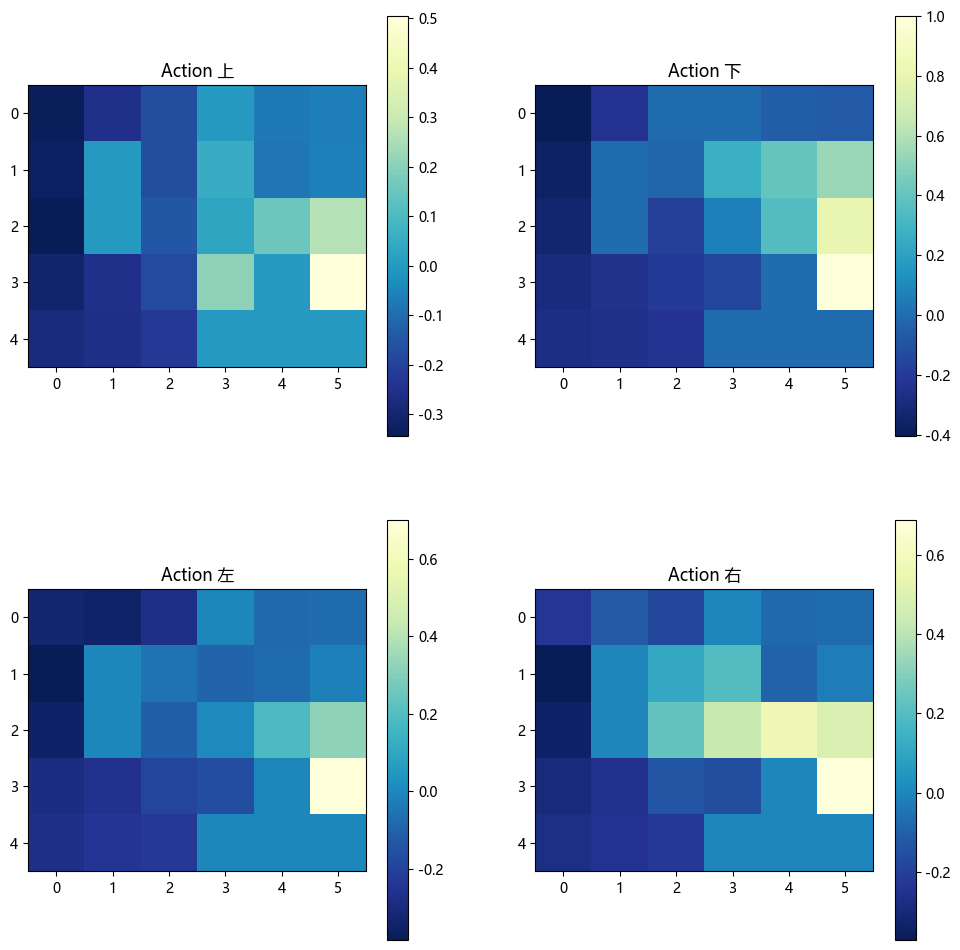

In [3]:
# 某个位置不同行为下的Q值热图，颜色越亮（即rgb值越大，通俗来说颜色越浅）

matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
matplotlib.rcParams['axes.unicode_minus'] = False

def plot_q_values(q_table : dict[(tuple, int), float], rows : int, cols : int, actions : List[int]) -> None:
    # 创建一个Q值矩阵
    q_values_matrix = numpy.zeros((rows, cols, len(actions)))

    for (state, action), value in q_table.items():
        q_values_matrix[state[0], state[1], action] = value

    # 创建热图
    
    _, axes = plt.subplots(2, 2, figsize=(12, 12))
    index = 0
    axes : List[List[Axes]]
    for r in range(2):
        for c in range(2):
            im = axes[r][c].imshow(q_values_matrix[:, :, index], cmap="YlGnBu_r")
            plt.colorbar(im)
            axes[r][c].set_title(f'Action {'上下左右'[index]}')
            index += 1
    plt.show()

qtables, scores = main()
plot_q_values(qtables, 5, 6, [0, 1, 2, 3])

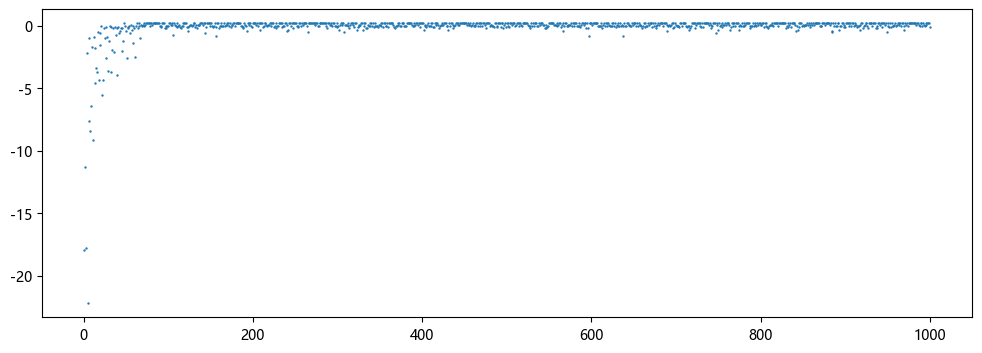

In [7]:
plt.figure(figsize=(12, 4))
plt.scatter(numpy.arange(1, 1001), scores, s=.5)
plt.show()